In [1]:
import numpy as np
import csv
from sklearn import neighbors, datasets, model_selection, metrics, __version__
from sklearn import tree as sk_tree
from math import log2
import pandas as pd
import os

## Creating the the different functions.

### starting with the tree class

In [2]:
#Simple tree structure with maximum 2 children
class Tree:
    #Containing a value, either a lable or tuple with information about split. Then each child is a new tree object.
    def __init__(self, value=None):
        self.value = value
        self.left = None
        self.right = None
        self.major_label = None
        
    

### Split labels
Making a function to split a list of labels on its mean. The split function is too simple, because it would split it on the datapoint with the mean.
I could sort the array, but I find it more simple and effective to retrieve the indexes instead and slice the points from the labels.

In [3]:
def split_label(feature, labels):
    #Finding feature mean
    feature_mean = np.nanmean(feature)
    #Splitting the feature on the mean
    left_labels = labels[np.nonzero(feature < feature_mean)]
    right_labels = labels[np.nonzero(feature >= feature_mean)]
    #np.nonzero function finds the index in an array with a condition. Here the conditions are based on the mean.
    return left_labels, right_labels, feature_mean
    

### Impurity and investigation score

In [4]:
def impurity(arr, impurity_measure = 'entropy'):
    #Starting sum
    entropy = 0
    gini = 0
    #Finding the counts for each possible label. Eihter one or two labels. 
    labels, counts = np.unique(arr, return_counts=True)
    #Calculating the entropy and gini for the array
    for count in counts:
        prob = count/len(arr)
        entropy -= prob*log2(prob)
        gini += prob*(1-prob)

    if impurity_measure == 'entropy':
        return entropy
    elif impurity_measure == 'gini':
        return gini

In [5]:
def cond_impurity(feature, labels, impurity_measure='entropy'):
    #Getting the labels for the split
    left_labels, right_labels, f_mean = split_label(feature, labels)
    
    #Finding the count of labels on each side
    left_len = len(left_labels)/len(feature)
    right_len = len(right_labels)/len(feature)

    #Calculating the impurity measure for the feature and each split, and multiplying with the split ratio
    impurity_left = impurity(left_labels, impurity_measure)*left_len
    impurity_right = impurity(right_labels, impurity_measure)*right_len

    #returning the conditional entropy
    return impurity_left + impurity_right

In [6]:
def investigation_score(feature, labels, impurity_measure='entropy'):

    #Getting the entropies
    entropy_feature = impurity(labels, impurity_measure)
    cond_entropy_feature = cond_impurity(feature, labels, impurity_measure)

    #Returning the investigation score
    return entropy_feature - cond_entropy_feature
    

### Finding the best feature to split on, by investigation score

In [7]:
def find_best_feature(data, labels, impurity_measure = 'entropy'):
    #Making a dictionary to store the feature key and the inv_score as value. 
    best_i = {}
    #Iterating through each feature
    for feature in range(data.shape[1]):
        best_i[feature] = investigation_score(data[:, feature], labels, impurity_measure)

    #Finding best feature with max function, where the key is the values. 
    #print(best_i.values())
    #if max(best_i.values()) > 0:
    best_feature_index = max(best_i, key= best_i.get)
    return best_feature_index

### Splitting the data and labels into subarrays
I chose to return a triple containing the left side, right side and value for the node

In [8]:
def split_data(data, labels, impurity_measure = 'entropy', feature_index='best', feature_mean='best'):
    
    #If we want to find best_feature or use a predetermined
    if feature_index == 'best':
        feature_index = find_best_feature(data, labels, impurity_measure)
        best_feature_mean = 'best'

    #Get the feature
    best_feature = data[:, feature_index]

    #Splitting the labels | Could have returned the labels in investigation_score to save compute, but this should be marginal.
    left_labels, right_labels, best_feature_mean = split_label(best_feature, labels)  
    
    #Splitting the data based on the indexes of what points is lower or higher than mean, given specific feature
    left_data = data[best_feature < best_feature_mean]
    right_data = data[best_feature >= best_feature_mean]
    
    #Returning a 3-tuple consisting of the left side, the right side and information about the split (what feature, the mean)
    #The latter will be stored in each branch when building the tree. 
    return (left_data, left_labels), (right_data, right_labels), (feature_index, best_feature_mean)
    

### Checking for identical features
The approach is if there is only one unique value in every column, then the multi array has identical rows. 

In [9]:
def identical_features(data, labels):
    count = 0
    for feature in range(data.shape[1]):
        if len(np.unique(data[:,feature])) == 1:
            count += 1
    
    if count == data.shape[1]:
        uniques, counts = np.unique(labels, return_counts=True)
        return uniques[np.argmax(counts)]

## Implementing the ID3 function by using the prior built functions


In [10]:
def id3(data, labels, tree, impurity_measure = 'entropy'):
    #Finding checking for identical features
    identical = identical_features(data, labels)
    
    #If all data points have the same label:
    if impurity(labels) == 0:
        tree.value = labels[0]
        return labels[0]

    #Else if all data points have identical feature values
    elif identical != None:
        tree.value = identical
        return


    #Else
    else:
        #Extracting the information from the split
        left, right, root = split_data(data, labels, impurity_measure)

        if root != 0:
            #Setting this root to indicate the split
            tree.value = root

            #Setting the majority label
            lab, counts = np.unique(labels, return_counts=True)
            maj_index = np.where(counts == max(counts))[0][0]
            tree.majority_label = lab[maj_index]
    
            #Making left branch
            new_left = Tree()
            tree.left = new_left
            id3(left[0], left[1], new_left, impurity_measure)
    
            #Making right branch
            new_right = Tree()
            tree.right = new_right 
            id3(right[0], right[1], new_right, impurity_measure)
        
        
        
    

## Creating some functions to inspect the tree

In [11]:
def search_tree(tree,count=0):
    if tree != None:
        counts = count
        counts += 1
        print(tree.value)
    
        search_tree(tree.left,counts)
        search_tree(tree.right,counts)

In [12]:
def total_nodes(tree):
    if tree == None:
        return 0

    l = total_nodes(tree.left)
    r = total_nodes(tree.right)

    return 1 + l + r
    

## Prediction and accuracy functions

In [13]:
def predict(data_point, tree):
    if type(tree.value) == tuple:
        feature, split_point = tree.value
        if data_point[feature] < split_point:
            return predict(data_point, tree.left)
        else:
            return predict(data_point, tree.right)
    else:
        return tree.value
    #print(tree.value)
    
    

In [14]:
def tree_accuracy(data, labels, tree):
    labels_len = len(labels)
    if labels_len == 0:
        return 0
    count = 0
    for counts, data_point in enumerate(data):
        if predict(data_point, tree) == labels[counts]:
            count += 1
    return count/labels_len

In [15]:
def predict_flat_label(data, labels, prediction=0):
    labels_len = len(labels)
    if labels_len == 0:
        return 0
    count = 0
    for counts, data_points in enumerate(data):
        if prediction == labels[counts]:
            count += 1
    return count/labels_len

## Pruning algorithm
In essence a Depth first search. Since I implemented the tree structure to have a left and right child, I dont have a child list. But it works the same since when using a for loop on a list of children, you start with the first one and its first one etc. So I'm doing left side first, then calling right side when the left is searched. Instead of for loop im just using running it recusively as long as the child is a tree object. Then on each child im calculating if the accuracy is higher with a lable instead of a split, and if so, the new value is a label.

If there is an empty array, then I'm not changing its branch. This is because the pruning data does not have the same data points as the training data. But when you calculate the accuracy and predictions with labels, they are all 0%. So the pruning data is not really suitable to determine wheter this split is necesarry or not. I have done some observations with different seeds and on average the accuracy declines when pruning these empty arrays. Hence im leaving the branches untouched.  

In [16]:
def prune(data, labels, tree, impurity_measure = 'entropy'):
    #Just want to do the pruning on a node that is splitting, not on a label node.
    if type(tree.value) == tuple:
        feature, mean = tree.value

        #Incase there are empty branches. If the the data and labels are empty, then there is no reason to split it, so the datapoints can stay as they were.
        #Since the accuracy is 0 with given data, but also 0 for either 0 or 1, so it would be unfair to choose one, because there is not enough data in pruning, to make a good decision.
        if len(labels) == 0:
            return
        else:
            left, right, values = split_data(data, labels, impurity_measure, feature_index = feature)
        
        
        
        #If there is a left 
        if type(tree.left) == Tree:
            prune(left[0], left[1], tree.left)
        if type(tree.right) == Tree:
            prune(right[0], right[1], tree.right)

        #Accuracy of either splitting or giving hard label
        for label in np.unique(labels):
            if predict_flat_label(data, labels, prediction=tree.majority_label) > tree_accuracy(data, labels, tree):
                #print('true')
                #print(tree.value, left[1], right[1], predict_flat_label(data, labels, prediction=label), accuracy(data, labels, tree))
                tree.value = tree.majority_label
                tree.left, tree.right = None, None
                #print(tree.value)

    

# The main learning algorithm

In [17]:
#Using the id3 algorithm to return a decision tree.
def learn(X, y, impurity_measure='entropy', pruning=False, train_ratio=0.8):
    #Making the root for the tree
    tree = Tree()

    #Checking whether the pruning is true
    if pruning == True:
        #Now we need to split the data
        train_ratio = train_ratio
        X_train, X_prune = np.split(X, [int(train_ratio*len(X))])
        y_train, y_prune = np.split(y, [int(train_ratio*len(y))])

        #Making the tree with training data
        id3(X_train, y_train, tree, impurity_measure)
        total_nodes(tree)

        #Pruning the tree with the pruning data
        prune(X_prune, y_prune, tree)
        total_nodes(tree)

        #Returning the pruned tree
        return tree
    
    #Else if pruning is false | Just make the tree and return it.
    else:
        id3(X, y, tree, impurity_measure)
        return tree

### read csv to numpy
Nice to have if we want to load more datasets

In [18]:
def cvs_numpy(name=''):
    with open(name, 'r') as r:
        reader = csv.reader(r)
        data = list(reader)
    
    feature_names = data[0][:-1]
    data_ar = np.array(data[1:], dtype=float)
    targets = data_ar[:, -1]
    data = data_ar[:, :-1]
    return data, targets, feature_names

# Testing withthe wine dataset

In [19]:
data, labels, target_names = cvs_numpy('wine_dataset.csv')#
seed = 333#332#333#521
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=seed)

In [20]:
data, labels, target_names

(array([[ 0.13,  1.6 ,  3.34,  0.59,  9.2 ],
        [ 0.1 ,  2.8 ,  3.6 ,  0.66, 10.2 ],
        [ 0.32,  1.9 ,  3.2 ,  0.55,  9.5 ],
        ...,
        [ 0.44,  1.6 ,  3.38,  0.86,  9.9 ],
        [ 0.36,  4.5 ,  3.4 ,  0.57, 10.4 ],
        [ 0.34,  6.4 ,  2.99,  0.4 , 10.8 ]]),
 array([1., 1., 1., ..., 1., 0., 0.]),
 ['citric acid', 'residual sugar', 'pH', 'sulphates', 'alcohol'])

In [21]:
tree = Tree()
tree= learn(X_train, y_train, impurity_measure='entropy')
tree_accuracy(X_train, y_train, tree)

1.0

In [22]:
tree_ = Tree()
tree_= learn(X_train, y_train, impurity_measure='gini', pruning=True, train_ratio=0.8)

In [23]:
tree.left.left.value
total_nodes(tree)


757

In [24]:
tree_accuracy(X_train, y_train, tree)

1.0

In [25]:
tree_accuracy(X_val_test, y_val_test, tree)


0.865625

In [26]:
tree_2 = Tree()
tree_2 = learn(X_train, y_train, impurity_measure='gini')

total_nodes(tree_2), tree_accuracy(X_val_test, y_val_test, tree_2)

(777, 0.8666666666666667)

In [27]:
#prune(X_val_test, y_val_test, tree_2)

In [28]:
total_nodes(tree_2)

777

In [29]:
(tree_accuracy(X_val_test, y_val_test, tree), total_nodes(tree)), (tree_accuracy(X_val_test, y_val_test, tree_2), total_nodes(tree_2))

((0.865625, 757), (0.8666666666666667, 777))

In [30]:
#predict_flat_label(X_val_test, y_val_test, 1)

In [31]:
search_tree(tree)

(1, 4.406836461126005)
(3, 0.6036129032258064)
(3, 0.5007070707070707)
(3, 0.4321588089330024)
(3, 0.38327777777777783)
(2, 3.161882352941176)
0.0
(1, 1.7875)
0.0
(1, 2.7866666666666666)
(0, 0.22625)
(0, 0.09)
(0, 0.04666666666666667)
(1, 2.25)
1.0
0.0
1.0
0.0
0.0
0.0
(0, 0.2971578947368421)
(0, 0.20836734693877548)
(0, 0.1305)
(2, 3.267777777777778)
(2, 3.11)
(1, 2.6)
1.0
0.0
0.0
1.0
(0, 0.1890909090909091)
0.0
(1, 2.0142857142857142)
(1, 1.475)
0.0
1.0
0.0
(1, 2.029310344827586)
(0, 0.25833333333333336)
(0, 0.23374999999999999)
(0, 0.21333333333333335)
0.0
1.0
0.0
0.0
(0, 0.26818181818181813)
(3, 0.40599999999999997)
0.0
(1, 2.875)
0.0
1.0
(3, 0.39999999999999997)
(0, 0.2833333333333334)
1.0
0.0
0.0
(3, 0.41173913043478266)
0.0
(4, 10.957142857142857)
(1, 1.711111111111111)
0.0
(2, 3.2024999999999997)
1.0
0.0
0.0
(0, 0.267219730941704)
(0, 0.1395959595959596)
(4, 10.057777777777776)
1.0
(0, 0.04933333333333333)
1.0
(1, 2.066666666666667)
(0, 0.10999999999999999)
0.0
(1, 1.85)
0.0
1.0

## Evaluating algorithm

Assess the performance of your algorithm using an appropriate performance
measure. Which setting should you select for this data (entropy or Gini,
pruning or no pruning)? What is your estimate for the performance of
the selected model on unseen data points? Report how you arrived at the
conclusi

ons.
Remember to use training, validation, and test sets properly. Note that in the
model selection step you select one out of the four models (settings) based
on performance on validation data, and in the model evaluation step you
evaluate the selected model on test data.

In [32]:
X_val, X_test = np.split(X_val_test, [int(len(X_val_test)/2)])
y_val, y_test = np.split(y_val_test, [int(len(y_val_test)/2)])

In [65]:
def best_ratio(train_data, train_labels, val_data, val_labels, impurity_measure):
    tree_prunefree = Tree()
    tree_prunefree = learn(train_data, train_labels, impurity_measure=impurity_measure)
    accuracy_prunefree = tree_accuracy(val_data, val_labels, tree_prunefree)
    #print(f'Prune free accuracy: {accuracy_prunefree}')
    ratios = {}
    
    for x in range(1,10):
        tree = Tree()
        tree = learn(train_data, train_labels, impurity_measure=impurity_measure, pruning=True, train_ratio=x/10)
        accuracy_tree = tree_accuracy(val_data, val_labels, tree)
        ratios[x/10] = accuracy_tree
        #print(f'Testing training ratio: {x/10}, with impurity_measure: gini, accuracy: {accuracy_tree:.3f} | Difference in accuracy: {accuracy_tree- accuracy_prunefree:.5f}')
    ratios[1] = accuracy_prunefree
    best_ratio = max(ratios, key=ratios.get)

    pruning = False
    if best_ratio != 1:
        pruning = True
    
    return [best_ratio, ratios[best_ratio], impurity_measure, pruning]

In [66]:
testing = np.array([best_ratio(X_train, y_train, X_val, y_val, impurity_measure='entropy'),
                    best_ratio(X_train, y_train, X_val, y_val, impurity_measure= 'gini')])
train_ratio, accuracy, impurity_measure, pruning = testing[np.argmax(testing[:, 1])]
print(f'The best model uses impurity measure: {impurity_measure}, with pruning: {pruning}, training ratio of: {train_ratio}, and an accuracy of: {accuracy.astype(float):.5f}')
print((pruning))
best_tree = learn(X_train, y_train, impurity_measure=impurity_measure, pruning=(pruning=='True'), train_ratio=train_ratio.astype(float))
print(f'The test accuracy on the best model is: {tree_accuracy(X_test, y_test, best_tree):.5f}')

The best model uses impurity measure: entropy, with pruning: True, training ratio of: 0.7, and an accuracy of: 0.87292
True
The test accuracy on the best model is: 0.87500


## SKLEARN test

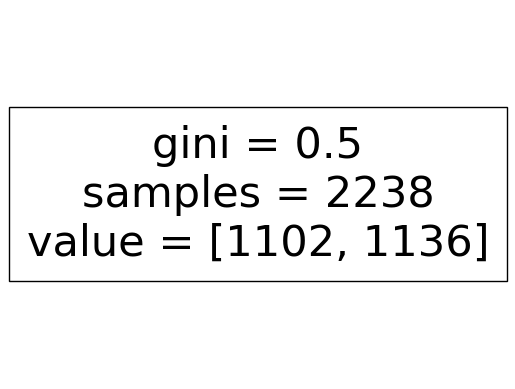

In [69]:
clf = sk_tree.DecisionTreeClassifier(criterion="gini",)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = sk_tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

clf = clf.fit(X_train, y_train)
sk_tree.plot_tree(clf)
tree = learn(X_train, y_train, impurity_measure='gini')


In [70]:
clfs

[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00022166834226988383, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0002647866812299341, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00027660751521341344, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0002813358488068051, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0002918057303350296, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.000294421237123401, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0002970290249572888, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0002980297425366092, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00036822492098987703, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00038299502106472626, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00040214477211796256, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00040214477211796256, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00040620684052319444, random_s

In [72]:
train_pred = clf.predict(X_train)
val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

train_acc = len(train_pred[train_pred == y_train])/len(y_train)
val_acc = len(val_pred[val_pred == y_val])/len(y_val)
test_acc =len(test_pred[test_pred == y_test])/len(y_test)
print(f'train: {train_acc}, {val_acc}, {test_acc}')
print("Accuracy sklearn:",metrics.accuracy_score(y_val, val_pred))
val_pred = []
for x in X_test:
    val_pred.append(predict(x, tree))

print("Accuracy my implementation:",metrics.accuracy_score(y_test, val_pred))


train: 0.5075960679177838, 0.45, 0.5145833333333333
Accuracy sklearn: 0.45
Accuracy my implementation: 0.8645833333333334


In [73]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

In [74]:
max(test_scores)

0.8958333333333334

## Testing with different dataset
found on kaggle: https://www.kaggle.com/datasets/abineshkumark/carsdata

In [37]:
df = pd.read_csv('cars.csv')
df

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.
...,...,...,...,...,...,...,...,...
256,17.0,8,305,130,3840,15,1980,US.
257,36.1,4,91,60,1800,16,1979,Japan.
258,22.0,6,232,112,2835,15,1983,US.
259,18.0,6,232,100,3288,16,1972,US.


In [38]:
data = df.to_numpy()
data

array([[14.0, 8, '350', ..., 12, 1972, ' US.'],
       [31.9, 4, '89', ..., 14, 1980, ' Europe.'],
       [17.0, 8, '302', ..., 11, 1971, ' US.'],
       ...,
       [22.0, 6, '232', ..., 15, 1983, ' US.'],
       [18.0, 6, '232', ..., 16, 1972, ' US.'],
       [22.0, 6, '250', ..., 15, 1977, ' US.']], dtype=object)

In [39]:
labels = data[:, -1]
data = data[:, :-1] 

In [40]:
data

array([[14.0, 8, '350', ..., '4209', 12, 1972],
       [31.9, 4, '89', ..., '1925', 14, 1980],
       [17.0, 8, '302', ..., '3449', 11, 1971],
       ...,
       [22.0, 6, '232', ..., '2835', 15, 1983],
       [18.0, 6, '232', ..., '3288', 16, 1972],
       [22.0, 6, '250', ..., '3353', 15, 1977]], dtype=object)

In [41]:
data[data[:, 2] == ' '] = 0 
for x in data[:,2]:
    x = int(x)

data[:, 2] = data[:, 2].astype(int)

data[data[:, 4] == ' '] = 0 
for x in data[:,4]:
    x = int(x)

data[:, 4] = data[:, 4].astype(int)

In [42]:
np.unique(labels, return_counts=True)

(array([' Europe.', ' Japan.', ' US.'], dtype=object),
 array([ 48,  51, 162], dtype=int64))

In [43]:
tree_3 = Tree()
tree_3 = learn(data, labels, impurity_measure='entropy', pruning='True')

In [44]:
impurity(labels[:70])

1.4013498193719667

In [45]:
tree_accuracy(data, labels, tree_3)

0.9961685823754789

In [46]:
predict(data[0], tree_3)

' US.'

In [47]:
labels[0]

' US.'